In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.optimize

from datetime import datetime
import pytz

import gm2
import trfp

Welcome to JupyROOT 6.12/04


In [ ]:
# # Blind trolley and fixed probe separately, but blind all fixed probe stations the same
# # Blind dipole by order 1 ppm = 61.79 Hz
# # Blind higher moments by order 100 ppb = 6.179 Hz
# tr_blinds = np.zeros(17)
# tr_blinds[0] = np.random.uniform(-61.79, 61.79)
# tr_blinds[1:] = np.random.uniform(-6.179, 6.179, 16)
# fp_blinds = np.zeros(6)
# fp_blinds[0] = np.random.uniform(-61.79, 61.79)
# fp_blinds[1:] = np.random.uniform(-6.179, 6.179, 5)

# def blind_tr_moment_df(moment_df, fp_blinds, tr_blinds):
#     out_df = moment_df.copy()
#     out_df['tr,m1'] = moment_df['tr,m1'] + tr_blinds[0]
#     for st in np.arange(72):
#         stm = 'st' + str(st) + ',m1'
#         out_df[stm] = moment_df[stm] + fp_blinds[0]
#     for m in np.arange(2,7):
#         trm = 'tr,m' + str(m)
#         out_df[trm] = moment_df[trm] + tr_blinds[m-1]
#         for st in np.arange(72):
#             stm = 'st' + str(st) + ',m' + str(m)
#             out_df[stm] = moment_df[stm] + fp_blinds[m-1]

#     # Blind higher order trolley moments by order 100 ppb = 6.179 Hz
#     for m in np.arange(7,18):
#         trm = 'tr,m' + str(m)
#         out_df[trm] = moment_df[trm] + tr_blinds[m-1]
        
#     return out_df

# def blind_fp_moment_df(moment_df, fp_blinds):
#     # Blind trolley and fixed probe separately, but blind all fixed probe stations the same
#     # Blind dipole by order 1 ppm = 61.79 Hz
#     out_df = moment_df.copy()
#     for st in np.arange(72):
#         stm = 'st' + str(st) + ',m1'
#         out_df[stm] = moment_df[stm] + fp_blinds[0]
    
#     # Blind quads, sexts, m6 by order 100 ppb = 6.179 Hz
#     for m in np.arange(2,7):
#         for st in np.arange(72):
#             stm = 'st' + str(st) + ',m' + str(m)
#             out_df[stm] = moment_df[stm] + fp_blinds[m-1]
        
#     return out_df

In [2]:
def trolley_run_station_average(corrected_df):
    station_phi = trfp.STATION_BARCODE_PHI
    station_edges = trfp.STATION_BARCODE_EDGES

    # tr_phi is not monotonic, so sort by tr_phi

    corrected_df = corrected_df.sort_values(by=['tr_phi'])

    measured_phi = corrected_df['tr_phi'].values
    measured_extent = (np.roll(measured_phi,-1)-np.roll(measured_phi,1))/2
    measured_extent[0] = measured_extent[0]+180
    measured_extent[-1] = measured_extent[-1]+180
    # print np.max(measured_extent)

    corrected_df['tr_extent'] = pd.Series(measured_extent, index=corrected_df.index)
    corrected_df = corrected_df.sort_index()

    # for a given station:
    # create a mask for when trolley is in [low edge, high edge)
    tr_baseline = np.full((72,17), np.nan)
    fp_baseline = np.full((72,6), np.nan)
    summed_azimuth = np.full(72, np.nan)
    summed_pts = np.full(72, np.nan)
    baseline_time = np.full(72, np.nan)

    for st in range(72): 
        if station_edges[st+1] > station_edges[st]:
            mask = (corrected_df['tr_phi'] >= station_edges[st]) & (corrected_df['tr_phi'] < station_edges[st+1])
        else:  # case where we go over the 360 deg line
            mask = (corrected_df['tr_phi'] >= station_edges[st]) | (corrected_df['tr_phi'] < station_edges[st+1])

        out_df = corrected_df[mask]
        summed_pts[st] = out_df.shape[0]
        summed_azimuth[st] = sum(out_df['tr_extent'].values)        
        baseline_time[st] = sum(out_df.index.values)/summed_pts[st]

        for m in range(17):
            st_id = 'tr,m'+str(m+1)
            if sum(out_df['tr_extent'].values) != 0:
                tr_baseline[st, m] = sum(out_df['tr_extent'].values*out_df[st_id].values)/sum(out_df['tr_extent'].values)
            else:
                tr_baseline[st, m] = np.nan
        for m in range(6):
            st_id = 'st'+str(st)+',m'+str(m+1)
            if sum(out_df['tr_extent'].values) != 0:
                fp_baseline[st, m] = np.mean(out_df[st_id])
            else:
                fp_baseline[st, m] = np.nan
    
    return tr_baseline, fp_baseline, baseline_time, summed_azimuth, summed_pts

In [3]:
def remove_trolley_effect(trolley_moment_df):
    '''DOC STRING'''
    barcode = trfp.STATION_BARCODE_PHI
    veto_extent = 25

    trolley_effect_removed_df = trolley_moment_df.copy()

    for st in range(72):
        print '\rRemoving trolley image from station ' + str(st) + '.',
        for m in range(1,7):
            st_m = 'st' + str(st) + ",m" + str(m)

            # Unwrap the fixed probe data versus trolley position
            raw_data = trolley_moment_df[['tr_phi', st_m]].copy()
            raw_low = raw_data.copy()
            raw_high = raw_data.copy()
            raw_low['tr_phi'] = raw_low['tr_phi'] - 360
            raw_high['tr_phi'] = raw_high['tr_phi'] + 360
            unwrap_nomask_df = pd.concat([raw_low, raw_data, raw_high])

            unwrap_mask_df = unwrap_nomask_df.copy()
#             # change mask to exclude 15 degrees instead of 7 (4 more degrees in either direction)
#             mask = ((unwrap_nomask_df['tr_phi']>barcode[st]-6) & (unwrap_nomask_df['tr_phi']<barcode[st]+9) |
#                     (unwrap_nomask_df['tr_phi']>barcode[st]-6-360) & (unwrap_nomask_df['tr_phi']<barcode[st]+9-360) |
#                     (unwrap_nomask_df['tr_phi']>barcode[st]-6+360) & (unwrap_nomask_df['tr_phi']<barcode[st]+9+360))
            # change mask to exclude 22 degrees
            veto_adjust = (veto_extent-7)/2
            mask = ((unwrap_nomask_df['tr_phi']>barcode[st]-2-veto_adjust) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+veto_adjust) |
                    (unwrap_nomask_df['tr_phi']>barcode[st]-2-veto_adjust-360) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+veto_adjust-360) |
                    (unwrap_nomask_df['tr_phi']>barcode[st]-2-veto_adjust+360) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+veto_adjust+360))
            unwrap_mask_df[st_m] = unwrap_nomask_df[st_m].mask(mask)
            unwrap_mask_df['tr_phi'] = unwrap_nomask_df['tr_phi']

            unwrap_filled_df = unwrap_mask_df.copy()
            temp = unwrap_filled_df.rolling(int(500),win_type='triang',min_periods=1,center=True).mean()
            temp = temp.rolling(int(500),win_type='triang',min_periods=1,center=True).mean()
            unwrap_filled_df[st_m] = unwrap_filled_df[st_m].mask(mask, temp[st_m])

            length = raw_data.shape[0]
            filled_df = unwrap_filled_df.iloc[length:2*length,:]

            trolley_effect_removed_df[st_m] = filled_df[st_m]

    print '\rFinished removing trolley images from ' + str(length) + ' events.'
    return trolley_effect_removed_df

In [4]:
station_phi = trfp.STATION_BARCODE_PHI
station_edges = trfp.STATION_BARCODE_EDGES

# corrected_df_1 = pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3956_corrected_df')
# # corrected_df_1 = blind_tr_moment_df(corrected_df_1, fp_blinds, tr_blinds)
# tr_baseline_1, fp_baseline_1, baseline_time_1, summed_azimuth_1, _ = trolley_run_station_average(corrected_df_1)

# corrected_df_2 = pd.read_hdf('60hr_trolley_runs_2.h5', key='run_3997_corrected_df')
# # corrected_df_2 = blind_tr_moment_df(corrected_df_2, fp_blinds, tr_blinds)
# tr_baseline_2, fp_baseline_2, baseline_time_2, summed_azimuth_2, _ = trolley_run_station_average(corrected_df_2)

corrected_df_1 = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3956_moment_df'))
tr_baseline_1, fp_baseline_1, baseline_time_1, summed_azimuth_1, _ = trolley_run_station_average(corrected_df_1)

corrected_df_2 = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_2.h5', key='run_3997_moment_df'))
tr_baseline_2, fp_baseline_2, baseline_time_2, summed_azimuth_2, _ = trolley_run_station_average(corrected_df_2)

# load all fixed probe runs moment_df into one big moment_df (runs 3959--3994)
print 'Appending fixed probe runs.'
fp_moment_df = pd.read_hdf('60hr_fixed_probe_runs.h5', key='run_3959_moment_df')
pts = fp_moment_df.shape[0]
for run in np.arange(3959, 3995):
    temp_df = pd.read_hdf('60hr_fixed_probe_runs.h5', key='run_'+str(run)+'_moment_df')
    pts = pts + temp_df.shape[0]
    print '\rAppending run ' + str(run) + '.',
    fp_moment_df = fp_moment_df.append(temp_df)
    
print '\nBlinding fixed probe runs.'
# fp_moment_df = blind_fp_moment_df(fp_moment_df, fp_blinds)

# load all the trolley runs corrected_df into on big file (to show window of 60hr set) ()
print '\nAppending trolley runs.'
tr_corrected_df = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3955_moment_df'))
for run in np.arange(3956, 3959):
    temp_df = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_1.h5', key='run_'+str(run)+'_moment_df'))
    pts = pts + temp_df.shape[0]
    print '\rAppending run ' + str(run) + '.',
    tr_corrected_df = tr_corrected_df.append(temp_df)
for run in np.arange(3995, 3999):
    temp_df = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_2.h5', key='run_'+str(run)+'_moment_df'))
    pts = pts + temp_df.shape[0]
    print '\rAppending run ' + str(run) + '.',
    tr_corrected_df = tr_corrected_df.append(temp_df)

print '\nDone appending runs.'

Finished removing trolley images from 4382 events.                                                            
Finished removing trolley images from 4359 events.                                                            
Appending fixed probe runs.
Appending run 3994.               
Blinding fixed probe runs.

Appending trolley runs.
Finished removing trolley images from 893 events.                          
Finished removing trolley images from 4382 events.                                                            
Finished removing trolley images from 2977 events.                                                            
Finished removing trolley images from 539 events.              
Finished removing trolley images from 365 events.         
Finished removing trolley images from 921 events.                          
Finished removing trolley images from 4359 events.                                                            
Finished removing trolley images from 2853 events.     

In [5]:
# print '\nBlinding trolley runs.'
# tr_corrected_df = blind_tr_moment_df(tr_corrected_df, fp_blinds, tr_blinds)

### Apply baseline corrections, generate virtual trolley measurements

fp_moment_baseline = fp_moment_df.copy()
fp_moment_tr_run_baseline = tr_corrected_df.copy()

# apply baseline corrections to each fp stm
print "\nSubtracting fixed probe baselines."
for st in np.arange(72):
    num_probes = len(trfp.STATION_PROBE_ID[st])
    for m in np.arange(num_probes):
        stm = 'st'+str(st)+',m'+str(m+1)
        
        def backwards_correction(time):
            c1 = fp_baseline_1[st, m]
            c2 = fp_baseline_2[st, m]
            t1 = baseline_time_1[st]
            t2 = baseline_time_2[st]
            return (c2-c1)/(t2-t1)*(time-t1) + c1
        
        correction = backwards_correction(fp_moment_baseline.index.values)
        fp_moment_baseline[stm] = fp_moment_baseline[stm] - correction
        correction = backwards_correction(fp_moment_tr_run_baseline.index.values)
        fp_moment_tr_run_baseline[stm] = fp_moment_tr_run_baseline[stm] - correction
        
        print '\rstm: ' + stm + '.',
        
# replace columns in vtr with Jacobian-fixed columns from fp baseline correction

print "\n\nApplying Jacobian."
vtr_df = fp_moment_df.copy()
vtr_tr_run_df = tr_corrected_df.copy()

for st in np.arange(72):
    num_probes = len(trfp.STATION_PROBE_ID[st])
    if num_probes == 4:
        num_moments = 4
        if st == 41:
            J = trfp.J_4_PROBE_ST41
        elif st == 37 | st == 39:
            J = trfp.J_4_PROBE_ST37_ST39
        else:
            J = trfp.J_4_PROBE
    else:
        num_moments = 5
        if st < 7:
            J = trfp.J_6_PROBE_OFFSET
        else:
            J = trfp.J_6_PROBE
#         J[0,4] = 0
    # run over each vtr moment:
    for m in np.arange(num_moments):
        vtr_stm = 'st'+str(st)+',m'+str(m+1)
        fp_stm = ['st'+str(st)+',m'+str(fp_m+1) for fp_m in np.arange(num_moments)]
        vtr_df[vtr_stm] = fp_moment_baseline[fp_stm].dot(J[m])
        vtr_tr_run_df[vtr_stm] = fp_moment_tr_run_baseline[fp_stm].dot(J[m])
        
        print '\rstm: ' + stm + '.',
        
# Add trolley baseline correction (with backwards correction)
print "\n\nAdding trolley baselines."

for st in np.arange(72):
    num_probes = len(trfp.STATION_PROBE_ID[st])
    for m in np.arange(num_probes):
        stm = 'st'+str(st)+',m'+str(m+1)
        
        def backwards_correction(time):
            c1 = tr_baseline_1[st, m]
            c2 = tr_baseline_2[st, m]
            t1 = baseline_time_1[st]
            t2 = baseline_time_2[st]
            return (c2-c1)/(t2-t1)*(time-t1) + c1
        
        correction = backwards_correction(vtr_df.index.values)
        vtr_df[stm] = vtr_df[stm] + correction
        correction = backwards_correction(vtr_tr_run_df.index.values)
        vtr_tr_run_df[stm] = vtr_tr_run_df[stm] + correction
        
        print '\rstm: ' + stm + '.',

print '\n\nDone.'


Subtracting fixed probe baselines.
stm: st71,m4.   

Applying Jacobian.
stm: st71,m4.          

Adding trolley baselines.
stm: st71,m4.     

Done.


In [8]:
### Apply NAIVE baseline corrections, generate virtual trolley measurements

fp_moment_baseline_naive = fp_moment_df.copy()
fp_moment_tr_run_baseline_naive = tr_corrected_df.copy()

# apply baseline corrections to each fp stm
print "\nSubtracting fixed probe baselines."
for st in np.arange(72):
    num_probes = len(trfp.STATION_PROBE_ID[st])
    for m in np.arange(num_probes):
        stm = 'st'+str(st)+',m'+str(m+1)
        
        def backwards_correction_naive(time):
            c1 = fp_baseline_1[st, m]
            return c1
        
        correction = backwards_correction_naive(fp_moment_baseline_naive.index.values)
        fp_moment_baseline_naive[stm] = fp_moment_baseline_naive[stm] - correction
        correction = backwards_correction_naive(fp_moment_tr_run_baseline_naive.index.values)
        fp_moment_tr_run_baseline_naive[stm] = fp_moment_tr_run_baseline_naive[stm] - correction
        
        print '\rstm: ' + stm + '.',
        
# replace columns in vtr with Jacobian-fixed columns from fp baseline correction

print "\n\nApplying Jacobian."
vtr_df_naive = fp_moment_df.copy()
vtr_tr_run_df_naive = tr_corrected_df.copy()

for st in np.arange(72):
    num_probes = len(trfp.STATION_PROBE_ID[st])
    if num_probes == 4:
        num_moments = 4
        if st == 41: J = trfp.J_4_PROBE_ST41
        elif st == 37 | st == 39: J = trfp.J_4_PROBE_ST37_ST39
        else: J = trfp.J_4_PROBE
    else:
        num_moments = 5
        if st < 7:
            J = trfp.J_6_PROBE_OFFSET
        else:
            J = trfp.J_6_PROBE
    # run over each vtr moment:
    for m in np.arange(num_moments):
        vtr_stm = 'st'+str(st)+',m'+str(m+1)
        fp_stm = ['st'+str(st)+',m'+str(fp_m+1) for fp_m in np.arange(num_moments)]
        vtr_df_naive[vtr_stm] = fp_moment_baseline_naive[fp_stm].dot(J[m])
        vtr_tr_run_df_naive[vtr_stm] = fp_moment_tr_run_baseline_naive[fp_stm].dot(J[m])
        
        print '\rstm: ' + stm + '.',
        
# Add trolley baseline correction (with backwards correction)
print "\n\nAdding trolley baselines."

for st in np.arange(72):
    num_probes = len(trfp.STATION_PROBE_ID[st])
    for m in np.arange(num_probes):
        stm = 'st'+str(st)+',m'+str(m+1)
        
        def backwards_correction_naive(time):
            c1 = tr_baseline_1[st, m]
            return c1
        
        correction = backwards_correction_naive(vtr_df_naive.index.values)
        vtr_df_naive[stm] = vtr_df_naive[stm] + correction
        correction = backwards_correction_naive(vtr_tr_run_df_naive.index.values)
        vtr_tr_run_df_naive[stm] = vtr_tr_run_df_naive[stm] + correction
        
        print '\rstm: ' + stm + '.',

print '\n\nDone.'


Subtracting fixed probe baselines.
stm: st71,m4.  

Applying Jacobian.
stm: st71,m4.          

Adding trolley baselines.
stm: st71,m4.  

Done.


In [7]:
# apply Jacobian to "glitches"

sync_offsets = np.empty((72,6))
sync_offsets[:] = np.nan
print "Apply Jacobian to calculate sync offsets."
for st in np.arange(72):
    num_probes = len(trfp.STATION_PROBE_ID[st])
    if num_probes == 4:
        num_moments = 4
        if st == 41: J = trfp.J_4_PROBE_ST41
        elif st == 37 | st == 39: J = trfp.J_4_PROBE_ST37_ST39
        else: J = trfp.J_4_PROBE
    else:
        num_moments = 5
        if st < 7:
            J = trfp.J_6_PROBE_OFFSET
        else:
            J = trfp.J_6_PROBE
    # run over each vtr moment:
    for m in np.arange(num_moments):
        sync_offsets[st,m] = ((tr_baseline_2[st,m] - np.dot(J[m,:], fp_baseline_2[st,0:num_moments]))
                              - (tr_baseline_1[st,m] - np.dot(J[m,:], fp_baseline_1[st,0:num_moments]))
                             )
        
        print '\rstm: ' + stm + '.',

print '\n\nDone.'

Apply Jacobian to calculate sync offsets.
stm: st71,m4. 

Done.


In [ ]:
print np.mean(sync_offsets[:,0])
print np.std(sync_offsets[:,0])

In [ ]:
#load raw data from fixed probe run 3960
run3960_raw = gm2.FixedProbe([3960])
run3960_interp = trfp.Run(3960)

_, fp_time, fp_freq = run3960_raw.getBasics()
fp_time = fp_time/1.0e9

In [9]:

# bin into the agreed upon bins

bins = np.arange(1524384055, 1524641055, 1000)-500
bin_centers = np.arange(1524384055, 1524640055, 1000)

vtr_time_bin_df = vtr_df.groupby(pd.cut(vtr_df.index,bins)).mean()
vtr_time_bin_df.index = bin_centers
vtr_time_bin_df.head()
test_df = vtr_time_bin_df.copy()

azi_avg_df = pd.DataFrame(np.zeros((test_df.shape[0],6)),
                         index = test_df.index,
                         columns = ['m' + str(m) for m in np.arange(6)+1])

weight = summed_azimuth_1+summed_azimuth_2
total_weight = np.sum(weight)

for m in np.arange(6):
    stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
    azi_avg_df['m'+str(m+1)] = test_df[stm_list].multiply(weight).sum(axis=1)/total_weight
    
azi_avg_df.head()/61.79

# azi_avg_df.to_csv('no_sext_correction')

,m1,m2,m3,m4,m5,m6
1524384055,841.719725,0.031245,0.151966,0.293791,-0.888723,1.605780
1524385055,841.720944,0.035776,0.151420,0.295265,-0.888281,1.604947
1524386055,841.721084,0.038070,0.152300,0.295373,-0.887390,1.607032
1524387055,841.712348,0.038238,0.152513,0.294991,-0.893638,1.607271
1524388055,841.719373,0.041318,0.152393,0.296023,-0.891135,1.609291


In [9]:
#####
#####
#####

# Plotting parameters (maybe define standard functions based on these reqs later?)

matplotlib.rc('xtick', labelsize=8)     
matplotlib.rc('ytick', labelsize=8)
matplotlib.rc('axes', titlesize=16)
matplotlib.rc('axes', labelsize=12)
plt.rcParams["font.family"] = "serif"
sns.set(style="darkgrid")

single_column_small = (6.202, 3.833)  #inches
single_column_med = (6.202, 6.202)
single_column_large = (6.202, 7.666)

def plt_unix_time_to_CST(ax):
    ax.locator_params(axis='x', nbins=5)
    xticks = ax.get_xticks()
    ax.set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z')
                          for tm in xticks], rotation=30)

def plt_set_labels(ax, x_label, y_label, title):
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

def fig_watermark(fig):
    fig.text(0.5, 0.5, 'BLINDED,\nPRELIMINARY',
         fontsize=24, color='black', rotation=45,
         ha='center', va='center', alpha=0.25)
    

In [ ]:
# fig:time_grid_sample

t_min = 1524396750
t_max = t_min + 500

mask = (fp_time[:,184]>=t_min)&(fp_time[:,184]<=t_max)
fp_range = fp_freq[:,184][mask]

y_center = (np.min(fp_range) + np.max(fp_range))/2
y_range = .55 * (np.max(fp_range) - np.min(fp_range))

fig, ax = plt.subplots(2,1)

plt.sca(ax[0])
plt.rcParams["font.family"] = "serif"
plt.plot(fp_time[10:,184],fp_freq[10:,184], '.', color='navy', markersize=6, label='Raw Data')
plt.plot(run3960_interp.interp_df.index.values,
         run3960_interp.interp_df['fp184'], '.', color='orange', markersize=6, label='Time Grid Data')
ax[0].set_xlim((t_min,t_max))
plt.locator_params(axis='x', nbins=5)
ax[0].set_ylim((y_center-y_range, y_center+y_range))
plt_unix_time_to_CST(ax[0])
plt_set_labels(ax[0], '', r"$\omega_p'$ - 61.74 MHz (Hz)", 'Fixed Probe 184')
ax[0].legend()

plt.sca(ax[1])
plt.rcParams["font.family"] = "serif"
plt.plot(fp_time[10:,184],fp_freq[10:,184], '.', color='navy', markersize=6, label='Raw Data')
plt.plot(run3960_interp.interp_df.index.values,
         run3960_interp.interp_df['fp184'], '.', color='orange', markersize=6, label='Time Grid Data')
ax[1].set_xlim((t_min+10,t_min+30))
plt.locator_params(axis='x', nbins=3)
ax[1].set_ylim((y_center-y_range, y_center+y_range))
plt_unix_time_to_CST(ax[1])
plt_set_labels(ax[1], '', r"$\omega_p'$ - 61.74 MHz (Hz)", 'Fixed Probe 184')
ax[1].legend()

fig.set_size_inches(single_column_large)
fig.tight_layout()
# fig.text(0.5, 0.5, 'PRELIMINARY', fontsize=24, color='black', rotation=45,
#          ha='center', va='center', alpha=0.25)
fig.savefig('time_grid_sample.png', dpi=300)

In [ ]:
# fig:time_grid_resids

t_min = 1524397050
t_max = 1524397250

def pentic_fit(t, a, b, c, d, e, f):
    t_0 = (np.max(t)+np.min(t))/2
    t = t-t_0
    return a + b*t + c*t**2 + d*t**3 + e*t**4 + f*t**5

mask = (fp_time[:,184]>=t_min)&(fp_time[:,184]<=t_max)
mask2 = (run3960_interp.interp_df.index.values>=t_min)&(run3960_interp.interp_df.index.values<=t_max)
fp_range = fp_freq[:,184][mask]
fp_range2 = run3960_interp.interp_df['fp184'][mask2]
time_range = fp_time[:,184][mask]
time_range2 = run3960_interp.interp_df.index.values[mask2]

c, _ = scipy.optimize.curve_fit(pentic_fit, time_range, fp_range)

fig, ax = plt.subplots(3,1)

plt.sca(ax[0])
plt.rcParams["font.family"] = "serif"
plt.plot(fp_time[10:,184],fp_freq[10:,184], '.', color='navy', markersize=6, label='Raw Data')
plt.plot(run3960_interp.interp_df.index.values,
         run3960_interp.interp_df['fp184'], '.', color='orange', markersize=6, label='Time Grid Data')
ax[0].set_xlim((t_min,t_max))
ax[0].set_ylim((y_center-y_range, y_center+y_range))
plt_unix_time_to_CST(ax[0])
plt_set_labels(ax[0], '', r"$\omega_p'$ - 61.74 MHz (Hz)", 'Fixed Probe 184')
ax[0].legend()

plt.sca(ax[1])
plt.rcParams["font.family"] = "serif"
plt.plot(time_range, fp_range - pentic_fit(time_range, c[0],c[1],c[2],c[3],c[4],c[5]), '.', color='navy',
         markersize=6, label='Raw Data')
plt.plot(time_range2, fp_range2 - pentic_fit(time_range2, c[0],c[1],c[2],c[3],c[4],c[5]),
         '.', color='orange', markersize=6, label='Time Grid Data')
ax[1].set_xlim((t_min,t_max))
plt_unix_time_to_CST(ax[1])
plt_set_labels(ax[1], '', r"$\omega_p'$ residuals (Hz)", 'Fixed Probe 184, Drift Removed')
ax[1].legend()

plt.sca(ax[2])
plt.rcParams["font.family"] = "serif"
plt.hist(fp_range - pentic_fit(time_range, c[0],c[1],c[2],c[3],c[4],c[5]), 20, color='navy', label='Raw Data')
plt.hist(fp_range2 - pentic_fit(time_range2, c[0],c[1],c[2],c[3],c[4],c[5]), 20, color='orange', label='Time Grid Data',
        alpha=0.5)
ax[2].set_xlim((-4,4))
plt_set_labels(ax[2], r"$\omega_p'$ residuals (Hz)", 'Counts', 'Fixed Probe 184 Residuals')
ax[2].legend()

fig.set_size_inches(single_column_large)
fig.tight_layout()
# fig.text(0.5, 0.5, 'PRELIMINARY', fontsize=36, color='black', rotation=45,
#          ha='center', va='center', alpha=0.25)

fig.savefig('time_grid_resids.png', dpi=300)

In [ ]:
# fig:trolley_image_removal
st=30
m=1
st_m = 'st' + str(st) + ",m" + str(m)

barcode = trfp.STATION_BARCODE_PHI
edges = trfp.STATION_BARCODE_EDGES

unwrap_nomask_df = pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3956_moment_df')
unwrap_mask_df = unwrap_nomask_df.copy()
# mask = ((unwrap_nomask_df['tr_phi']>barcode[st]-2) & (unwrap_nomask_df['tr_phi']<barcode[st]+5) |
#         (unwrap_nomask_df['tr_phi']>barcode[st]-2-360) & (unwrap_nomask_df['tr_phi']<barcode[st]+5-360) |
#         (unwrap_nomask_df['tr_phi']>barcode[st]-2+360) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+360))
# unwrap_mask_df[st_m] = unwrap_nomask_df[st_m].mask(mask)
# unwrap_mask_df['tr_phi'] = unwrap_nomask_df['tr_phi']

veto_extent = 25
# change mask to exclude 22 degrees
veto_adjust = (veto_extent-7)/2
mask = ((unwrap_nomask_df['tr_phi']>barcode[st]-2-veto_adjust) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+veto_adjust) |
        (unwrap_nomask_df['tr_phi']>barcode[st]-2-veto_adjust-360) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+veto_adjust-360) |
        (unwrap_nomask_df['tr_phi']>barcode[st]-2-veto_adjust+360) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+veto_adjust+360))
unwrap_mask_df[st_m] = unwrap_nomask_df[st_m].mask(mask)
unwrap_mask_df['tr_phi'] = unwrap_nomask_df['tr_phi']

run3956_corrected_df = remove_trolley_effect(unwrap_nomask_df)

fig, ax = plt.subplots(3,1)

plt.sca(ax[0])
plt.rcParams["font.family"] = "serif"
plt.plot(unwrap_nomask_df['tr_phi'], unwrap_nomask_df['st30,m1'], '.', color='navy', markersize=4)
plt.axvline(edges[30], 0, 1, color='orange', label='Station Extent')
plt.axvline(edges[31], 0, 1, color='orange')
plt.hlines(50600, edges[30], edges[31], color='orange')
ax[0].set_xlim((120, 160))
ax[0].set_ylim((50200, 51000))
ax[0].legend()
plt_set_labels(ax[0], 'Trolley Position (deg)', 'm1 - 61.74 MHz (Hz)', 'Station 30 Trolley Image, Run 3956')

plt.sca(ax[1])
plt.rcParams["font.family"] = "serif"
plt.plot(unwrap_mask_df['tr_phi'], unwrap_mask_df['st30,m1'], '.', color='navy', markersize=4)
plt.axvline(edges[30], 0, 1, color='orange', label='Station Extent')
plt.axvline(edges[31], 0, 1, color='orange')
plt.hlines(50308.5, edges[30], edges[31], color='orange')
ax[1].set_xlim((120,160))
ax[1].set_ylim((50303,50314))
ax[1].legend()
plt_set_labels(ax[1], 'Trolley Position (deg)', 'm1 - 61.74 MHz (Hz)', 'Trolley Image Veto Window')

plt.sca(ax[2])
plt.rcParams["font.family"] = "serif"
plt.plot(run3956_corrected_df['tr_phi'], run3956_corrected_df['st30,m1'], '.', color='navy', markersize=4)
plt.axvline(edges[30], 0, 1, color='orange', label='Station Extent')
plt.axvline(edges[31], 0, 1, color='orange')
plt.hlines(50308.5, edges[30], edges[31], color='orange')
ax[2].set_xlim((120,160))
ax[2].set_ylim((50303,50314))
ax[2].legend()
plt_set_labels(ax[2], 'Trolley Position (deg)', 'm1 - 61.74 MHz (Hz)', 'Veto Window Interpolated')

fig.set_size_inches(single_column_large)
fig.tight_layout()
# fig_watermark(fig)

fig.savefig('trolley_image_removal.png', dpi=300)

In [ ]:
# fig:baseline_results

fig, ax = plt.subplots(3,1)

plt.sca(ax[0])
plt.rcParams["font.family"] = "serif"
plt.plot(baseline_time_1-np.min(run3956_corrected_df.index.values), '.')
plt_set_labels(ax[0], 'Fixed Probe Station', 'Baseline Time\n(sec from run start)', 'Averaging Baselines')

plt.sca(ax[1])
plt.rcParams["font.family"] = "serif"
plt.plot(tr_baseline_1[:,0], '.')
ax[1].set_ylim((45000,65000))
plt_set_labels(ax[1], 'Fixed Probe Station', 'Baseline Trolley\n$m_1$ - 61.74 MHz (Hz)', '')


plt.sca(ax[2])
plt.rcParams["font.family"] = "serif"
plt.plot(fp_baseline_1[:,0], '.')
ax[2].set_ylim((45000,65000))
plt_set_labels(ax[2], 'Fixed Probe Station', 'Baseline Fixed Probe\n$m_1$ - 61.74 MHz (Hz)', '')


fig.set_size_inches(single_column_med)
fig.tight_layout()
# fig_watermark(fig)

fig.savefig('baseline_results', dpi=300)

/home/aetb/.local/lib/python2.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home/aetb/.local/lib/python2.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


ValueError: max must be larger than min in range parameter.

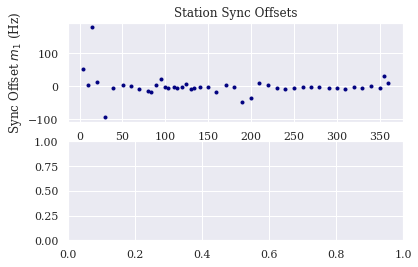

In [11]:
m = 5
trolley_moment = 'tr,m'+str(m)
# fit gaussian to histogrammed glitches
def gaussian_norm(x, sigma, mu, A):
    return 9*72/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/(2*sigma**2))


fig7, ax7 = plt.subplots(2,1)
plt.sca(ax7[0])
plt.rcParams["font.family"] = "serif"
plt.plot(station_phi, sync_offsets[:,m-1], '.', color='navy')
ax7[0].set_xlabel(r'$\phi$ (deg)')
ax7[0].set_ylabel(r'Sync Offset $m_1$ (Hz)')
ax7[0].set_title(r'Station Sync Offsets')

plt.sca(ax7[1])
plt.rcParams["font.family"] = "serif"
glitch_hist, glitch_edges, _ = plt.hist(sync_offsets[:,m-1], 72)
glitch_bins = (glitch_edges[0:-1] + glitch_edges[1:])/2
bin_width = glitch_edges[3] - glitch_edges[2]

# fit gaussian to histogrammed glitches
def gaussian_norm(x, sigma, mu):
    return bin_width*72/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/(2*sigma**2))

c, _ = scipy.optimize.curve_fit(gaussian_norm, glitch_bins, glitch_hist, p0=(21,-13))

fit_coeffs = '$\mu$ = '+str(np.round(c[1],2))+'\n $\sigma$ = '+str(np.round(c[0],2))
plt.plot(np.arange(-300,301,0.5), gaussian_norm(np.arange(-300,301,0.5), c[0], c[1]),
         color='orange', label = fit_coeffs)
ax7[1].legend()
ax7[1].set_xlim((-300,300))
ax7[1].set_xlabel('$m_1$ Sync Offset (Hz)')
ax7[1].set_ylabel('Counts')
ax7[1].set_title('Sync Offsets')

fig7.set_size_inches(single_column_med)
fig7.tight_layout()
# fig_watermark(fig7)

# fig2.savefig('baseline_comparison_1.png', dpi=300)
# fig7.savefig('glitch_hist.png', dpi=300)

[-4.91135291e+00  3.26174912e+01  9.79529258e+00  5.28577255e+01
  5.46501702e+00  1.78911228e+02  1.22705626e+01 -9.33034358e+01
 -3.63590940e+00  4.17621233e+00  2.37450353e+00 -7.75253781e+00
 -1.40036700e+01 -1.76731980e+01  3.07293712e+00  2.13367477e+01
 -1.53802397e+00 -4.26293877e+00 -1.08268196e+00 -5.83561537e+00
 -1.23902336e+00  6.31575166e+00 -7.06840833e+00 -4.40037617e+00
 -5.54947855e-01 -2.67031084e+00 -1.60371531e+01  5.65412806e+00
 -1.74605416e+00 -4.83161324e+01 -3.36684403e+01  9.36624460e+00
  3.32839189e+00 -5.72505828e+00 -8.74984755e+00 -5.54806447e+00
 -1.35839497e+00 -3.01267847e+00 -2.24980875e+00 -5.06462912e+00
 -4.14941846e+00 -7.51825468e+00 -2.39004224e+00 -4.67628403e+00
  1.48170721e-01]
[350.17 354.33 358.84   4.34   9.33  14.23  20.2   29.33  39.33  50.2
  59.34  69.34  80.17  83.32  89.31  94.33  99.31 103.3  110.19 113.31
 119.34 124.32 129.3  133.27 140.21 149.34 159.36 170.19 179.36 189.36
 200.17 209.34 219.34 230.22 239.36 249.38 260.2  269.3

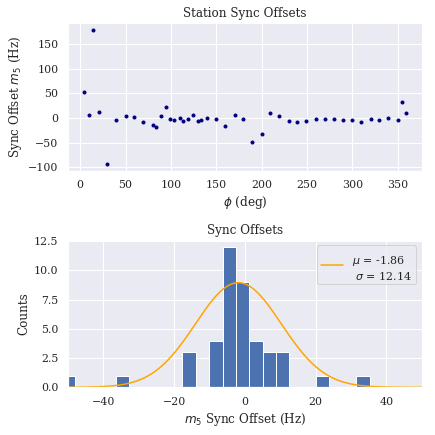

In [21]:
six_probe =  [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 34, 36, 38,
       40, 42, 44, 46,48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70]
print sync_offsets[:,4][six_probe]
print np.array(station_phi)[six_probe]

station_phi = np.array(trfp.STATION_BARCODE_PHI)

m = 5
trolley_moment = 'tr,m'+str(m)
# fit gaussian to histogrammed glitches
def gaussian_norm(x, sigma, mu, A):
    return 9*72/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/(2*sigma**2))


fig7, ax7 = plt.subplots(2,1)
plt.sca(ax7[0])
plt.rcParams["font.family"] = "serif"
plt.plot(station_phi[six_probe], sync_offsets[:,m-1][six_probe], '.', color='navy')
ax7[0].set_xlabel(r'$\phi$ (deg)')
ax7[0].set_ylabel(r'Sync Offset $m_5$ (Hz)')
ax7[0].set_title(r'Station Sync Offsets')

plt.sca(ax7[1])
plt.rcParams["font.family"] = "serif"
glitch_hist, glitch_edges, _ = plt.hist(sync_offsets[:,m-1][six_probe], 72)
glitch_bins = (glitch_edges[0:-1] + glitch_edges[1:])/2
bin_width = glitch_edges[3] - glitch_edges[2]

# fit gaussian to histogrammed glitches
def gaussian_norm(x, sigma, mu):
    return bin_width*72/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/(2*sigma**2))

c, _ = scipy.optimize.curve_fit(gaussian_norm, glitch_bins, glitch_hist, p0=(21,-13))

fit_coeffs = '$\mu$ = '+str(np.round(c[1],2))+'\n $\sigma$ = '+str(np.round(c[0],2))
plt.plot(np.arange(-300,301,0.5), gaussian_norm(np.arange(-300,301,0.5), c[0], c[1]),
         color='orange', label = fit_coeffs)
ax7[1].legend()
ax7[1].set_xlim((-50,50))
ax7[1].set_xlabel('$m_5$ Sync Offset (Hz)')
ax7[1].set_ylabel('Counts')
ax7[1].set_title('Sync Offsets')

fig7.set_size_inches(single_column_med)
fig7.tight_layout()

In [ ]:
# fig:vtr_naive

st = 30
m = 1
stm = 'st'+str(st)+',m'+str(m)

fig, ax = plt.subplots(2,1)
plt.sca(ax[0])
plt.rcParams["font.family"] = "serif"
plt.plot(fp_moment_df.index.values, fp_moment_df[stm], '.', color='navy', markersize=2)
plt.plot(tr_corrected_df.index.values, tr_corrected_df[stm], '.', color='orange', markersize=2)
plt.locator_params(axis='x', nbins=5)
plt_unix_time_to_CST(ax[0])
ax[0].set_ylabel('fp moment (ppm)')
ax[0].set_title('fp '+stm)
plt_set_labels(ax[0], '', '$m_1$ - 61.74 MHz (Hz)', 'fp '+stm)

plt.sca(ax[1])
plt.rcParams["font.family"] = "serif"
plt.plot(vtr_df_naive.index.values, vtr_df_naive[stm], '.', color='navy', markersize=2)
plt.plot(vtr_tr_run_df_naive.index.values, vtr_tr_run_df_naive[stm], '.', color='navy', markersize=2)
plt.plot(baseline_time_1[st], tr_baseline_1[st, m-1], 'X', color='orange', markersize=9)
plt.locator_params(axis='x', nbins=10)
plt_unix_time_to_CST(ax[1])
plt_set_labels(ax[1], '', '$m_1$ - 61.74 MHz (Hz)', 'vtr '+stm)

fig.set_size_inches(single_column_med)
fig.tight_layout()
# fig_watermark(fig)

fig.savefig('vtr_naive.png', dpi=300)

In [ ]:
# fig:glitch_demo
st = 2
m = 1
stm = 'st' + str(st) +',m'+str(m)

fig, ax = plt.subplots(1,1)

plt.sca(ax)
plt.rcParams["font.family"] = "serif"
plt.plot(vtr_df_naive.index.values, vtr_df_naive[stm], '.', color='navy', markersize=2)
plt.plot(vtr_tr_run_df_naive.index.values, vtr_tr_run_df_naive[stm], '.', color='navy', markersize=2)
plt.plot(baseline_time_1[st], tr_baseline_1[st, m-1], 'X', color='orange', markersize=9)
plt.plot(baseline_time_2[st], tr_baseline_2[st, m-1], 'X', color='orange', markersize=9)
ax.set_ylim((50000,50800))
plt.locator_params(axis='x', nbins=10)
plt_unix_time_to_CST(ax)
plt_set_labels(ax, '', '$m_1$ - 61.74 MHz (Hz)', 'vtr '+stm)

fig.set_size_inches(single_column_small)
fig.tight_layout()
# fig_watermark(fig)

fig.savefig('glitch_demo.png', dpi=300)

In [ ]:
# fig:backward_correction_demo
st = 2
m = 1
stm = 'st' + str(st) +',m'+str(m)

fig, ax = plt.subplots(1,1)
plt.sca(ax)
plt.rcParams["font.family"] = "serif"
plt.plot(vtr_df.index.values, vtr_df[stm], '.', color='navy', markersize=2)
plt.plot(vtr_tr_run_df.index.values, vtr_tr_run_df[stm], '.', color='navy', markersize=2)
plt.plot(baseline_time_1[st], tr_baseline_1[st, m-1], 'X', color='orange', markersize=9)
plt.plot(baseline_time_2[st], tr_baseline_2[st, m-1], 'X', color='orange', markersize=9)
ax.set_ylim((50000,50800))
plt_unix_time_to_CST(ax)
plt_set_labels(ax, '', '$m_1$ - 61.74 MHz (Hz)',
               'vtr '+stm + ', Interpolated Sync, Offset = %.1f Hz'%sync_offsets[st,0])

fig.set_size_inches(single_column_small)
fig.tight_layout()
# fig_watermark(fig)

fig.savefig('backward_correction_demo.png', dpi=300)

In [ ]:
# fig:time_binning

st = 30
m = 1
stm = 'st' + str(st) +',m'+str(m)

fig, ax = plt.subplots(2,1)

plt.sca(ax[0])
plt.rcParams["font.family"] = "serif"
plt.plot(vtr_df.index.values, vtr_df[stm], '.', color='navy', markersize=2, label='Before Time Average')
plt.plot(vtr_time_bin_df.index.values, vtr_time_bin_df[stm], '.', color='orange', markersize=2, label='Time Average')
plt.plot(baseline_time_1[st], tr_baseline_1[st, m-1], 'X', color='orange', markersize=9)
plt.plot(baseline_time_2[st], tr_baseline_2[st, m-1], 'X', color='orange', markersize=9)
ax[0].legend()

plt_unix_time_to_CST(ax[0])
plt_set_labels(ax[0], '', '$m_1$ - 61.74 MHz (Hz)', 'vtr '+stm + ' Time Binned')

plt.sca(ax[1])
plt.rcParams["font.family"] = "serif"
plt.plot(vtr_df.index.values, vtr_df[stm], '.', color='navy', markersize=2, label='Before Time Average')
plt.plot(vtr_time_bin_df.index.values, vtr_time_bin_df[stm], '.', color='orange', markersize=10, label='Time Average')
ax[1].legend()
ax[1].set_xlim((t_min,t_min+30000))
ax[1].set_ylim((51880,51950))
plt_unix_time_to_CST(ax[1])
plt_set_labels(ax[1], '', '$m_1$ - 61.74 MHz (Hz)', 'vtr '+stm + ' Time Binned')

fig.set_size_inches(single_column_large)
fig.tight_layout()
# fig_watermark(fig)

fig.savefig('time_binning.png', dpi=300)

In [ ]:
# fig:final_dipole
fig1,ax1 = plt.subplots(1,1)
plt.rcParams["font.family"] = "serif"
plt.plot(azi_avg_df.index.values, azi_avg_df['m1'], '.', color='navy', markersize=2)
# ax1.set_ylim(51900,52000)
plt_unix_time_to_CST(ax1)
plt_set_labels(ax1, '', '$m_1$ - 61.74 MHz (Hz)', 'Azimuthally Averaged Dipole')

fig1.set_size_inches(single_column_small)
fig1.tight_layout()
# fig_watermark(fig1)


# fig:final_nquad
fig2,ax2 = plt.subplots(1,1)
plt.rcParams["font.family"] = "serif"
plt.plot(azi_avg_df.index.values, azi_avg_df['m2'], '.', color='navy', markersize=2)
# ax2.set_ylim(-30,30)
plt_unix_time_to_CST(ax2)
plt_set_labels(ax2, '', '$m_2$ (Hz)', 'Azimuthally Averaged Normal Quad')

fig2.set_size_inches(single_column_small)
fig2.tight_layout()
# fig_watermark(fig2)


# fig:final_squad
fig3,ax3 = plt.subplots(1,1)
plt.rcParams["font.family"] = "serif"
plt.plot(azi_avg_df.index.values, azi_avg_df['m3'], '.', color='navy', markersize=2)
# ax3.set_ylim(0,20)
plt_unix_time_to_CST(ax3)
plt_set_labels(ax3, '', '$m_3$ (Hz)', 'Azimuthally Averaged Skew Quad')

fig3.set_size_inches(single_column_small)
fig3.tight_layout()
# fig_watermark(fig3)


# # fig:final_nsext
# fig4,ax4 = plt.subplots(1,1)
# plt.rcParams["font.family"] = "serif"
# plt.plot(azi_avg_df.index.values, azi_avg_df['m5'], '.', color='navy', markersize=2)
# ax4.set_ylim(-60,-40)
# plt_unix_time_to_CST(ax4)
# plt_set_labels(ax4, '', '$m_3$ (Hz)', 'Azimuthally Averaged Normal Sextupole')

# fig4.set_size_inches(single_column_small)
# fig4.tight_layout()
# fig_watermark(fig4)


fig1.savefig('final_dipole.png', dpi=300)
fig2.savefig('final_nquad.png', dpi=300)
fig3.savefig('final_squad.png', dpi=300)
# fig4.savefig('final_nsext.png', dpi=300)

In [ ]:
# corrected_df = pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3956_corrected_df')
# tr_baseline_1, fp_baseline_1, baseline_time_1, summed_azimuth_1, _ = trfp.trolley_run_station_average(corrected_df)

# trolley_moment = 'tr,m'+str(m)

# fig2, ax2 = plt.subplots(2,1)
# plt.sca(ax2[0])
# plt.plot(corrected_df['tr_phi'],corrected_df[trolley_moment]/61.79, '.', color='navy')
# plt.plot(station_phi, tr_baseline_1[:,m-1]/61.79, '.', color='orange', markersize=12)
# ax2[0].set_xlabel('phi (deg)')
# ax2[0].set_ylabel('field moment (ppm)')
# ax2[0].set_title('Trolley Baseline')
# plt.sca(ax2[1])
# plt.plot(station_phi, fp_baseline_1[:,m-1]/61.79, '.', color='orange', markersize=12)
# ax2[1].set_xlabel('phi (deg)')
# ax2[1].set_ylabel('field moment (ppm)')
# ax2[1].set_title('Fixed Probe Baseline')

# fig2.tight_layout()
# fig2.set_size_inches(12,6)

# print trolley_moment+':'
# baseline_mean = sum(summed_azimuth_1*tr_baseline_1[:,m-1])/sum(summed_azimuth_1)
# print '\tWeighted average of all station-trolley baselines with a posteri station extent: %0.4f'%(baseline_mean/61.79)

# corrected_df = pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3957_corrected_df')
# tr_baseline_2, fp_baseline_2, baseline_time_2, summed_azimuth_2, _ = trfp.trolley_run_station_average(corrected_df)

# m = 1
# trolley_moment = 'tr,m'+str(m)

# fig3, ax3 = plt.subplots(2,1)
# plt.sca(ax3[0])
# plt.plot(corrected_df['tr_phi'],corrected_df[trolley_moment]/61.79, '.', color='navy')
# plt.plot(station_phi, tr_baseline_2[:,m-1]/61.79, '.', color='orange', markersize=12)
# ax3[0].set_xlabel('phi (deg)')
# ax3[0].set_ylabel('field moment (ppm)')
# ax3[0].set_title('Trolley Baseline')
# plt.sca(ax3[1])
# plt.plot(station_phi, fp_baseline_2[:,m-1]/61.79, '.', color='orange', markersize=12)
# ax3[1].set_xlabel('phi (deg)')
# ax3[1].set_ylabel('field moment (ppm)')
# ax3[1].set_title('Fixed Probe Baseline')

# fig3.tight_layout()
# fig3.set_size_inches(12,6)

# print trolley_moment+':'
# baseline_mean = sum(summed_azimuth_2*tr_baseline_2[:,m-1])/sum(summed_azimuth_2)
# print '\tWeighted average of all station-trolley baselines with a posteri station extent: %0.4f'%(baseline_mean/61.79)

# fig4, ax4 = plt.subplots(1,1)
# plt.sca(ax4)
# plt.plot((tr_baseline_1[:,1]-tr_baseline_2[:,1])/61.79, '.', color = 'navy', label='Tr Baseline')
# plt.plot((fp_baseline_1[:,1]-fp_baseline_2[:,1])/61.79, '.', color = 'orange', label='Fp Baseline')
# ax4.set_xlabel('phi (deg)')
# ax4.set_ylabel(r'$\Delta$ field moment (ppm)')
# ax4.set_title('CCW minus CW run baselines')
# ax4.legend()
# fig4.tight_layout()
# fig4.set_size_inches(12,6)